# 9.1 Experiencing ROS2

This is the end of our journey!. And last but not least... we're going to experience the amazing [Robot Operating System 2 (ROS2) ecosystem](https://docs.ros.org/en/humble/index.html).

For that, we are going to use the [MVSim](https://mvsimulator.readthedocs.io/en/latest/index.html), a lightweight MultiVehicle Simulator: 

> Lightweight, realistic dynamical simulator for 2D (“2.5D”) vehicles and robots. It is tailored to analysis of vehicle dynamics, wheel-ground contact forces, and accurate simulation of typical robot sensors.
This project includes C++ and Python libraries, the standalone CLI application mvsim, and ROS 1 and ROS 2 nodes, and it is licensed under the permissive 3-clause BSD License.

<center><video width=" " height=" " 
       src="./images/mvsim_demo_greenhouse.mp4"  
       controls>
</video></center>

## 9.1.1 Preparing the path

For working with ROS2 and MVSim you will need:
- Ubuntu 22.04 (you can natively install it, or through a Virtual Machine (e.g., VMWare or WSL).
- ROS2 (https://docs.ros.org/en/humble/Installation/Ubuntu-Install-Debians.html). You will need both the *Desktop installation* and *Development tools*.
- MVSim (https://mvsimulator.readthedocs.io/en/latest/install.html).

**<font color="red">Important!</font>** ROS2 relies on a number of environment variables to work properly, so we need to load them in our terminal. This can be done through the `source` command, which executes the commands from a file in the current shell:

```bash
source /opt/ros/humble/setup.bash 
```

However, executing the command in that manner requires you to load the variables each time you open a new terminal. To solve this, you can add the `source` command to your `.bashrc` file, which is automatically executed every time a new terminal session is started, ensuring that the necessary variables are consistently loaded:

```bash
echo "source /opt/ros/humble/setup.bash" >> ~/.bashrc
```

Later on you will repeat this but with the environment variables of your workspace.

You can also install terminator for managing terminals:

```bash
sudo apt install terminator
```

## 9.1.2 Insight into MVSim

MVSim simulates a world as defined in a `.world` file. It could be illustrative to take a look at any of them, hey are placed at: `/opt/ros/humble/share/mvsim/mvsim_tutorial`. This file tells MVSim everything about the world, from obstacles, to robots, sensors, and other objects in the virtual environment. Depending on the world you are running, the available topics can change. 

<center><video width=" " height=" " 
       src="./images/mvsim_demo_1robot.mp4"  
       controls>
</video></center>

The following is an example for the world shown above:

```xml
    <mvsim_world version="1.0">
        <!-- General simulation options -->
        <simul_timestep>0</simul_timestep> <!-- Simulation fixed-time interval for numerical integration [seconds] or 0 to autodetermine -->

        <!-- GUI options -->
        <gui>
                <ortho>false</ortho>
                <show_forces>true</show_forces>  <force_scale>0.01</force_scale>
                <cam_distance>35</cam_distance>
                <fov_deg>60</fov_deg>
                <refresh_fps>20</refresh_fps>
                <!-- <follow_vehicle>r1</follow_vehicle> -->
        </gui>

        <!-- Light parameters -->
        <lights>
        </lights>

        <!-- ========================
                   Scenario definition
             ======================== -->
        <element class="occupancy_grid">
                <!-- File can be an image or an MRPT .gridmap file -->
                <file>uma_campus.gridmap.gz</file>

                <!--<show_collisions>true</show_collisions>-->
        </element>

        <!-- ground grid (for visual reference) -->
        <element class="ground_grid">
                <floating>true</floating>
        </element>

        <!-- =============================
                   Vehicle classes definition
             ============================= -->
        <include file="../definitions/ackermann.vehicle.xml" />

        <!-- ========================
                   Vehicle(s) definition
             ======================== -->
        <vehicle name="r1" class="car_ackermann">
                <init_pose>0 0 0</init_pose>  <!-- In global coords: x,y, yaw(deg) -->
                <init_vel>0 0 0</init_vel>  <!-- In local coords: vx,vy, omega(deg/s) -->

                <!-- Sensors -->
                <include file="../definitions/lidar2d.sensor.xml" sensor_x="1.7" sensor_z="1.01" sensor_yaw="0" max_range="70.0" sensor_name="laser1" />
                <include file="../definitions/lidar2d.sensor.xml" sensor_x="-0.5" sensor_z="1.01" sensor_yaw="180" max_range="70.    0" sensor_name
```>
</launch>="laser2" />
        </vehicle>

</mvsim_world>

MVSim also comes with a number of launch files for working with these demo worlds. For example, `demo_1robot.launch`:

```xml
<?xml version="1.0"?>
<!-- ROS1 launch file. See *.launch.py files for ROS2 launch files -->
<launch>
        <arg name="world_file" default="$(find mvsim)/mvsim_tutorial/demo_1robot.world.xml" />
        <arg name="mvsim_do_fake_localization" default="true"/>

        <node pkg="mvsim" type="mvsim_node" name="mvsim_simulator" output="screen">
                <param name="world_file" value="$(arg world_file)"/>
                <param name="do_fake_localization" value="$(arg mvsim_do_fake_localization)"/>
        </node>

        <node pkg="rviz" type="rviz" name="rviz" args="-d $(find mvsim)/mvsim_tutorial/demo_1robot.rviz"/>
</launch>
```

With its python-based counterpart:

```python
# ROS2 launch file

from launch import LaunchDescription
from launch.substitutions import TextSubstitution
from launch.substitutions import LaunchConfiguration
from launch_ros.actions import Node
from launch.actions import DeclareLaunchArgument
from ament_index_python import get_package_share_directory
import os


def generate_launch_description():
    mvsimDir = get_package_share_directory("mvsim")
    #print('mvsimDir: ' + mvsimDir)

    # args that can be set from the command line or a default will be used
    world_file_launch_arg = DeclareLaunchArgument(
        "world_file", default_value=TextSubstitution(
            text=os.path.join(mvsimDir, 'mvsim_tutorial', 'demo_1robot.world.xml')))

    mvsim_node = Node(
        package='mvsim',
        executable='mvsim_node',
        name='mvsim',
        output='screen',
        parameters=[
            os.path.join(mvsimDir, 'mvsim_tutorial', 'mvsim_ros2_params.yaml'),
            {
                "world_file": LaunchConfiguration('world_file'),
            }]
    )

    rviz2_node = Node(
        package='rviz2',
        executable='rviz2',
        name='rviz2',
        arguments=[
                '-d', [os.path.join(mvsimDir, 'mvsim_tutorial', 'demo_1robot_ros2.rviz')]]
    )

    return LaunchDescription([
        world_file_launch_arg,
        mvsim_node,
        rviz2_node
    ])
```

### **<span style="color:green"><b><i>ASSIGNMENT 1: Analyzing topics</i></b></span>** 

**What to do?**

- Run the demo world with a robot with `ros2 launch mvsim demo_1robot.launch.py`
- Check the available topics and include them in a list below, also stating which nodes publish/subscribes to them (rqt_graph can help here).

<p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>

### **<span style="color:green"><b><i>ASSIGNMENT 2: Manually controlling the robot</i></b></span>** 

One of the topics MVSim is suscribed to is `/cmd_vel`, so we can send motion commands to the robot:

```bash
ros2 topic pub /cmd_vel geometry_msgs/msg/Twist "{linear: {x: 0.5, y: 0.0, z: 0.0}, angular: {x: 0.0, y: 0.0, z: 0.0}}"
```

**What to do?**

- Send some motion commands, and take some screenshots of them and the robot. You can send a motion command full of zeros to stop it!

Take care commanding the robot, it can crash otherwise!

<p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>


### **<span style="color:green"><b><i>ASSIGNMENT 3: Implementing reactive navigation</i></b></span>** 

Finally, we are going to implement a reactive navigation technique so our robot can safely move through the environment. Recall this pipeline when developing ROS 2 software:

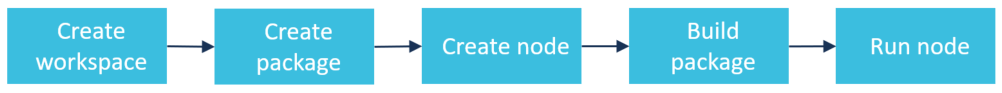

Some handy ROS 2 links: 
- [Workspace creation tutorial](https://docs.ros.org/en/humble/Tutorials/Beginner-Client-Libraries/Creating-A-Workspace/Creating-A-Workspace.html)
- [Package creation tutorial](https://docs.ros.org/en/humble/Tutorials/Beginner-Client-Libraries/Creating-Your-First-ROS2-Package.html)
- [Example of a simple publisher and subscriber](https://docs.ros.org/en/humble/Tutorials/Beginner-Client-Libraries/Writing-A-Simple-Py-Publisher-And-Subscriber.html)
- [List of ROS 2 tutorials](https://docs.ros.org/en/humble/Tutorials.html)

**What to do?**

1. Create a **ROS 2 workspace**.
   - Once created, add its `setup.bash`file to your shell configuration: `echo "source ~/humble_ws/install/setup.bash" >> ~/.bashrc`
2. Create a **package** (it can be python or c++ based). The name is of your choice!
   - CAUTION! this has to be done in the ``src`` directory of your workspace.
   - Customize the ``package.xml`` file.
3. Craete a **node**, and implement in it the Potential Fields technique (or any other reactive navigation technique of your choice). For example, the next line creates a package called `reactive_nav` with a node named `potential_fields_nav`, using `ament_python` to specify that it will be a Python package:
```bash
ros2 pkg create --build-type ament_python --node-name potential_fields_nav reactive_nav
``` 

During the node implementation notice that:
- You can perceive the environment through the information provided by the laser. This is a **subscription**.
- You can also send motion commands. Here the node plays the role of a **publisher**.
- The robot true pose is also provided to you in a topic (`/base_pose_ground_truth`). Second **subscription**.
- You can use RViz to listen to new goal destinations through the `/goal_pose` topic. Third and last **subscription**.
- You have to include the dependencies of your package into the `package.xml`.
- Check that your node appears in `setup.py`as an entry point.

**Provide here**: screenshots of the content of the `/src` directory of your workspace, of your package, and the code of your node.

<p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>

### **<span style="color:green"><b><i>ASSIGNMENT 4: Testing your reactive navigator</i></b></span>** 

Let's test our node. For that, use the RViz visualizer to send motion commands to the four positions in the next image, they have an increasing complexity. You have to:
- start the needed nodes,
- send a new goal pose through RViz, and
- record the screen or take screenshots to see how your robot is moving and reaches that goal.
  
Do this for each of the 4 goal positions. You don't have to concatenate goal poses, you have to start each time from the beginning.

<figure style="text-align:center">
  <img src="images/mvsim_goal_to_positions.png" alt="">
</figure>

<p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>

### **<span style="color:green"><b><i>OPTIONAL: Try other worlds</i></b></span>** 

MVSim comes with different demo world. Try your navigation technique with others and discuss the results.

<p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>

### **<span style="color:green"><b><i>OPTIONAL: Improve the technique</i></b></span>** 

The Potential Fields navigation technique admits different improvements upon this baseline version. Implement any of your choice, and include here a discussion about it and some resources illustrating how the robot behaviour improves.

<p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>